In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.isomorphism import GraphMatcher, DiGraphMatcher
from itertools import combinations, chain
from mlxtend.frequent_patterns import apriori, association_rules

# Hallo

In [3]:
# Edgelist

E1 = [("A", "B"), ("B", "C"), ("C", "D"), ("D", "E"), ("E", "F")]
E2 = [("A", "B"), ("B", "C"), ("C", "D"), ("C", "E"), ("D", "F")]
# , ("C", "D"), ("D", "E")
# E3 = [("A", "E"), ("A", "B"), ("A", "C"), ("A", "D")]

In [4]:
# Directed graphs

G1 = nx.DiGraph()
G2 = nx.DiGraph()
G1.add_edges_from(E1)
G2.add_edges_from(E2)

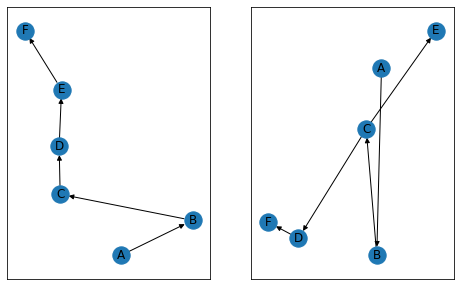

In [6]:
# Draw graphs 

plt.figure(figsize=(8,5))
plt.figure(1)

plt.subplot(1,2,1)
nx.draw_networkx(G1)

plt.subplot(1,2,2)
nx.draw_networkx(G2)

plt.show()

In [7]:
# Apriori algorithm

GRAPH_DB = [G1, G2]  # List of graphs in the database
edge_matrix = [E1, E2]  # List of edge lists
min_sup = 2

def frequent_singletons(min_sup, edge_matrix):
    items_counted = {}
    for edge_list in edge_matrix:
        for edge in edge_list:
            items_counted[edge] = items_counted.get(edge, 0) + 1
    
    # Return frequent edges that meet the min_sup
    F = [key for key, value in items_counted.items() if value >= min_sup]
    
    # Convert frequent edges into individual graph objects
    F_graphs = [nx.DiGraph([edge]) for edge in F]  # Each edge is a graph now
    return F_graphs

F = frequent_singletons(2, edge_matrix)

def generate_candidates(F, k):
    # Generate combinations of subgraphs from frequent subgraphs of size (k-1)
    candidates = set()
    
    # Iterate over all pairs of frequent subgraphs (F)
    for g1, g2 in combinations(F, 2):
        # Combine the two subgraphs if they share a common (k-1)-sized subgraph
        union_graph = nx.compose(g1, g2)
        
        # if nx.is_connected(union_graph): Denne funktion eksisterer ikke for directed graphs
        
        if union_graph.number_of_nodes() == k+1:
            candidates.add(union_graph)
    
    return candidates


def count_support(C, graph_db):
    F_count = dict()
    for graph in graph_db:
        for candidate in C:
            GM = DiGraphMatcher(graph, candidate)
            if GM.subgraph_is_isomorphic():  # Check for subgraph isomorphism
                F_count[candidate] = F_count.get(candidate, 0) + 1
    return F_count


def filter_frequent(F_count, min_sup):
    return [key for key, value in F_count.items() if value >= min_sup]


# Main function to run the frequent subgraph mining algorithm
def apriori_graph_mining(min_sup, edge_matrix, graph_db, max_k):
    frequent_total = []
    
    # Step 1: Find frequent singletons (edges)
    F = frequent_singletons(min_sup, edge_matrix)
    
    # Add initial frequent items to the total list
    frequent_total.extend(F)
    
    k = 2  # Start with size-2 subgraphs
    while k <= max_k:
        print(f"\nIteration {k}:")
        
        # Step 2: Generate candidate subgraphs of size k
        C = generate_candidates(F, k)
        
        # Step 3: Count support for each candidate in the graph database
        F_count = count_support(C, graph_db)
        
        # Step 4: Filter out frequent candidates that meet the minimum support
        F = filter_frequent(F_count, min_sup)
        
        if not F:  # If no frequent candidates are found, stop the algorithm
            print(f"No frequent subgraphs found for size {k}. Terminating.")
            break
        
        # Add frequent items to the total list
        frequent_total.extend(F)
        
        print(f"Frequent subgraphs of size {k}: {F}")
        
        k += 1  # Move to the next size of subgraphs

    return frequent_total


# Illustration af hver gennemgang af algoritmen

In [8]:
F = frequent_singletons(2, edge_matrix)
C = generate_candidates(F, 2)
count = count_support(C, GRAPH_DB)
filter = filter_frequent(count, 2)

for i in filter:
    print(i.edges())

[('B', 'C'), ('C', 'D')]
[('A', 'B'), ('B', 'C')]


In [9]:
C2 = generate_candidates(C, 3)
count2 = count_support(C2, GRAPH_DB)
filter2 = filter_frequent(count2, 2)

for i in filter2:
    print(i.edges())

[('B', 'C'), ('C', 'D'), ('A', 'B')]


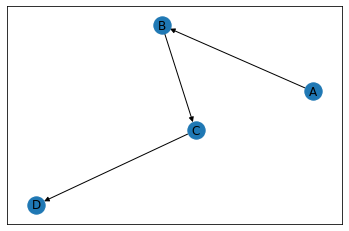

In [10]:
nx.draw_networkx(filter2[0])

In [11]:
C3 = generate_candidates(C2, 4)
count3 = count_support(C3, GRAPH_DB)
filter3 = filter_frequent(count3, 2)

In [12]:
filter3

[]

# Illustration af algoritmen på en gang

In [13]:
frequents = apriori_graph_mining(2, edge_matrix, GRAPH_DB, 5)
for pattern in frequents:
    print(pattern.edges())


Iteration 2:
Frequent subgraphs of size 2: [<networkx.classes.digraph.DiGraph object at 0x000001E347AC0640>, <networkx.classes.digraph.DiGraph object at 0x000001E3479458D0>]

Iteration 3:
Frequent subgraphs of size 3: [<networkx.classes.digraph.DiGraph object at 0x000001E347944040>]

Iteration 4:
No frequent subgraphs found for size 4. Terminating.
[('A', 'B')]
[('B', 'C')]
[('C', 'D')]
[('A', 'B'), ('B', 'C')]
[('B', 'C'), ('C', 'D')]
[('A', 'B'), ('B', 'C'), ('C', 'D')]
